In [1]:
# Importing all the necessary packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
from sklearn import cross_validation
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.cross_validation import cross_val_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import log_loss

In [2]:
X_train = pd.read_csv('auto_x.csv', index_col=0)   # auto_x
y_train = pd.read_csv('auto_y.csv', index_col=0)   # auto_y

In [3]:
cnts_vars_final = list(pd.read_csv('cnt_vars.csv')['0'])
cat_vars_final = list(pd.read_csv('cat_vars.csv')['0'])
var = cnts_vars_final
var.extend(cat_vars_final)

In [4]:
# function for xgboost
def modelfit(alg, dtrain, predictors, useTrainCV=True, cv_folds=5, early_stopping_rounds=50):
    
    if useTrainCV:
        xgb_param = alg.get_xgb_params()
        xgtrain = xgb.DMatrix(dtrain[predictors].values, label=y_train[[0]].values)
        cvresult = xgb.cv(xgb_param, xgtrain, num_boost_round=alg.get_params()['n_estimators'], nfold=cv_folds,
                          metrics=['logloss'], early_stopping_rounds=early_stopping_rounds, show_progress=False)
        alg.set_params(n_estimators=cvresult.shape[0])
    
    #Fit the algorithm on the data
    alg.fit(dtrain[predictors], np.ravel(y_train),eval_metric='logloss')
        
    #Predict training set:
    dtrain_predictions = alg.predict(dtrain[predictors])
    dtrain_predprob = alg.predict_proba(dtrain[predictors])[:,1]
        
    #Print model report:
    print "\nModel Report"
    print "AUC Score (Train): %f" % roc_auc_score(np.ravel(y_train), dtrain_predprob)
    
    feat_imp = pd.Series(alg.booster().get_fscore()).sort_values(ascending=False)
    feat_imp.plot(kind='bar', title='Feature Importances')
    plt.ylabel('Feature Importance Score')

In [5]:
# xgboost classifier
xgb1 = XGBClassifier(learning_rate =0.03, n_estimators=300, max_depth=2, reg_alpha = 0.005, min_child_weight=5, gamma=0.3,
                     colsample_bytree=0.8, subsample=0.8, reg_lambda = 1.2, max_delta_step=3,
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=45)

Will train until cv error hasn't decreased in 50 rounds.



Model Report
AUC Score (Train): 0.988038


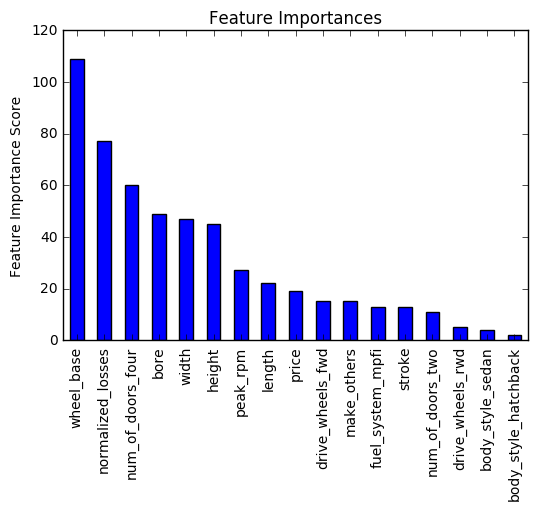

In [6]:
#Choose the predictors for xgboost and fit the model
predictors = var
modelfit(xgb1, X_train, predictors)

In [7]:
# Train log_loss
y_predS = xgb1.predict_proba(X_train[var])
log_loss(y_train, y_predS[:,1])

0.17895139832123744

In [8]:
# Tune tree pruning parameters: max_depth and min_child_weight
param_test1 = {
   'max_depth':[2, 3, 4, 5, 6],
    'min_child_weight':[1, 2, 3, 4, 5, 6, 10, 15, 100]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=170, max_depth=3, min_child_weight=6,
                    reg_alpha = 0, reg_lambda = 1, gamma=0, colsample_bytree=0.6, subsample=0.9, max_delta_step=0,
                    objective= 'binary:logistic', nthread=5, scale_pos_weight=1, seed=45), 
 param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.48336, std: 0.12936, params: {'max_depth': 2, 'min_child_weight': 1},
  mean: -0.48703, std: 0.12041, params: {'max_depth': 2, 'min_child_weight': 2},
  mean: -0.45747, std: 0.12832, params: {'max_depth': 2, 'min_child_weight': 3},
  mean: -0.43576, std: 0.12343, params: {'max_depth': 2, 'min_child_weight': 4},
  mean: -0.41906, std: 0.12022, params: {'max_depth': 2, 'min_child_weight': 5},
  mean: -0.42321, std: 0.11276, params: {'max_depth': 2, 'min_child_weight': 6},
  mean: -0.46502, std: 0.12419, params: {'max_depth': 2, 'min_child_weight': 10},
  mean: -0.61173, std: 0.03189, params: {'max_depth': 2, 'min_child_weight': 15},
  mean: -0.69315, std: 0.00000, params: {'max_depth': 2, 'min_child_weight': 100},
  mean: -0.47603, std: 0.14569, params: {'max_depth': 3, 'min_child_weight': 1},
  mean: -0.46592, std: 0.15043, params: {'max_depth': 3, 'min_child_weight': 2},
  mean: -0.45010, std: 0.12842, params: {'max_depth': 3, 'min_child_weight': 3},
  mean: -0.43332, std: 0

In [9]:
# Tune gamma
param_test1 = {
'gamma':[i/10.0 for i in range(0,5)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=170, max_depth=3, min_child_weight=5,
                    reg_alpha = 0, reg_lambda = 1, gamma=0, colsample_bytree=0.6, subsample=0.9, max_delta_step=0,
                    objective= 'binary:logistic', nthread=5, scale_pos_weight=1, seed=45), 
 param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch1.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.41530, std: 0.12232, params: {'gamma': 0.0},
  mean: -0.41703, std: 0.12297, params: {'gamma': 0.1},
  mean: -0.41655, std: 0.12336, params: {'gamma': 0.2},
  mean: -0.41738, std: 0.12176, params: {'gamma': 0.3},
  mean: -0.41631, std: 0.12266, params: {'gamma': 0.4}],
 {'gamma': 0.0},
 -0.41529819954983632)

In [10]:
# Tune sample size and number of columns for a single tree
param_test1 = {
'subsample':[i/10.0 for i in range(6,10)],
 'colsample_bytree':[i/10.0 for i in range(4,10)]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=170, max_depth=3, min_child_weight=5,
                    reg_alpha = 0, reg_lambda = 1, gamma=0.0, colsample_bytree=0.6, subsample=0.9, max_delta_step=0,
                    objective= 'binary:logistic', nthread=5, scale_pos_weight=1, seed=45), 
 param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch2.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.41596, std: 0.09991, params: {'subsample': 0.6, 'colsample_bytree': 0.4},
  mean: -0.40896, std: 0.10154, params: {'subsample': 0.7, 'colsample_bytree': 0.4},
  mean: -0.40338, std: 0.11000, params: {'subsample': 0.8, 'colsample_bytree': 0.4},
  mean: -0.40780, std: 0.11509, params: {'subsample': 0.9, 'colsample_bytree': 0.4},
  mean: -0.43108, std: 0.10609, params: {'subsample': 0.6, 'colsample_bytree': 0.5},
  mean: -0.41978, std: 0.10801, params: {'subsample': 0.7, 'colsample_bytree': 0.5},
  mean: -0.41780, std: 0.11267, params: {'subsample': 0.8, 'colsample_bytree': 0.5},
  mean: -0.41781, std: 0.12051, params: {'subsample': 0.9, 'colsample_bytree': 0.5},
  mean: -0.43916, std: 0.11327, params: {'subsample': 0.6, 'colsample_bytree': 0.6},
  mean: -0.42389, std: 0.11341, params: {'subsample': 0.7, 'colsample_bytree': 0.6},
  mean: -0.42023, std: 0.12026, params: {'subsample': 0.8, 'colsample_bytree': 0.6},
  mean: -0.41530, std: 0.12232, params: {'subsample': 0.9, 'colsa

In [11]:
# Tune regularization parameter: reg_alpha
param_test1 = {
'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=170, max_depth=3, min_child_weight=5,
                    reg_alpha = 0, reg_lambda = 1, gamma=0.0, colsample_bytree=0.4, subsample=0.8, max_delta_step=0,
                    objective= 'binary:logistic', nthread=5, scale_pos_weight=1, seed=45), 
 param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch3.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.40338, std: 0.11000, params: {'reg_alpha': 1e-05},
  mean: -0.40356, std: 0.11107, params: {'reg_alpha': 0.01},
  mean: -0.40379, std: 0.10937, params: {'reg_alpha': 0.1},
  mean: -0.40765, std: 0.11352, params: {'reg_alpha': 1},
  mean: -0.69315, std: 0.00000, params: {'reg_alpha': 100}],
 {'reg_alpha': 1e-05},
 -0.40337593397542615)

In [12]:
# Tune regularization parameters: reg_lambda
param_test1 = {
    'reg_lambda':[0, 1, 1.1, 1.2, 1.5, 2, 3, 5]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=170, max_depth=3, min_child_weight=5,
                    reg_alpha = 1e-05, reg_lambda = 1, gamma=0.0, colsample_bytree=0.4, subsample=0.8, max_delta_step=0,
                    objective= 'binary:logistic', nthread=5, scale_pos_weight=1, seed=45), 
 param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch4.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.40867, std: 0.11003, params: {'reg_lambda': 0},
  mean: -0.40338, std: 0.11000, params: {'reg_lambda': 1},
  mean: -0.40278, std: 0.10946, params: {'reg_lambda': 1.1},
  mean: -0.40198, std: 0.10784, params: {'reg_lambda': 1.2},
  mean: -0.40243, std: 0.11309, params: {'reg_lambda': 1.5},
  mean: -0.40499, std: 0.11180, params: {'reg_lambda': 2},
  mean: -0.40816, std: 0.11439, params: {'reg_lambda': 3},
  mean: -0.41300, std: 0.11164, params: {'reg_lambda': 5}],
 {'reg_lambda': 1.2},
 -0.40198443174844062)

In [13]:
param_test1 = {
'max_delta_step':[0, 1, 2, 3, 4, 5, 10, 100]
}

gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=170, max_depth=3, min_child_weight=5,
                    reg_alpha = 1e-05, reg_lambda = 1.2, gamma=0.0, colsample_bytree=0.4, subsample=0.8, max_delta_step=0,
                    objective= 'binary:logistic', nthread=5, scale_pos_weight=1, seed=45), 
 param_grid = param_test1, scoring='log_loss',n_jobs=4,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch5.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.40198, std: 0.10784, params: {'max_delta_step': 0},
  mean: -0.40411, std: 0.11050, params: {'max_delta_step': 1},
  mean: -0.40198, std: 0.10784, params: {'max_delta_step': 2},
  mean: -0.40198, std: 0.10784, params: {'max_delta_step': 3},
  mean: -0.40198, std: 0.10784, params: {'max_delta_step': 4},
  mean: -0.40198, std: 0.10784, params: {'max_delta_step': 5},
  mean: -0.40198, std: 0.10784, params: {'max_delta_step': 10},
  mean: -0.40198, std: 0.10784, params: {'max_delta_step': 100}],
 {'max_delta_step': 0},
 -0.40198443174844062)

In [14]:
param_test1 = {
'scale_pos_weight':[0, 1, 2, 5, 10, 50, 100]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=170, max_depth=3, min_child_weight=5,
                    reg_alpha = 1e-05, reg_lambda = 1.2, gamma=0.0, colsample_bytree=0.4, subsample=0.8, max_delta_step=0,
                    objective= 'binary:logistic', nthread=5, scale_pos_weight=1, seed=45), 
 param_grid = param_test1, scoring='log_loss',n_jobs=5,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch6.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -1.18451, std: 0.00024, params: {'scale_pos_weight': 0},
  mean: -0.40198, std: 0.10784, params: {'scale_pos_weight': 1},
  mean: -0.41879, std: 0.12286, params: {'scale_pos_weight': 2},
  mean: -0.47767, std: 0.13852, params: {'scale_pos_weight': 5},
  mean: -0.53514, std: 0.15214, params: {'scale_pos_weight': 10},
  mean: -0.67888, std: 0.19944, params: {'scale_pos_weight': 50},
  mean: -0.76416, std: 0.24458, params: {'scale_pos_weight': 100}],
 {'scale_pos_weight': 1},
 -0.40198443174844062)

In [15]:
param_test1 = {
'learning_rate':[0.03, 0.05], 
'n_estimators':[250, 300, 350, 500, 700]
}
gsearch1 = GridSearchCV(estimator = XGBClassifier(learning_rate =0.05, n_estimators=170, max_depth=3, min_child_weight=5,
                    reg_alpha = 1e-05, reg_lambda = 1.2, gamma=0.0, colsample_bytree=0.4, subsample=0.8, max_delta_step=0,
                    objective= 'binary:logistic', nthread=5, scale_pos_weight=1, seed=45), 
 param_grid = param_test1, scoring='log_loss',n_jobs=5,iid=False, cv=3)
gsearch1.fit(X_train[var],np.ravel(y_train))
pd.Series(gsearch1.grid_scores_).to_csv('/home/pgoyal/Projects/gsresearch7.csv')
gsearch1.grid_scores_, gsearch1.best_params_, gsearch1.best_score_

([mean: -0.41337, std: 0.11863, params: {'n_estimators': 250, 'learning_rate': 0.03},
  mean: -0.41280, std: 0.11683, params: {'n_estimators': 300, 'learning_rate': 0.03},
  mean: -0.41263, std: 0.11534, params: {'n_estimators': 350, 'learning_rate': 0.03},
  mean: -0.42034, std: 0.12131, params: {'n_estimators': 500, 'learning_rate': 0.03},
  mean: -0.43080, std: 0.11697, params: {'n_estimators': 700, 'learning_rate': 0.03},
  mean: -0.40535, std: 0.11452, params: {'n_estimators': 250, 'learning_rate': 0.05},
  mean: -0.41101, std: 0.11439, params: {'n_estimators': 300, 'learning_rate': 0.05},
  mean: -0.41497, std: 0.10924, params: {'n_estimators': 350, 'learning_rate': 0.05},
  mean: -0.43082, std: 0.10517, params: {'n_estimators': 500, 'learning_rate': 0.05},
  mean: -0.44343, std: 0.09076, params: {'n_estimators': 700, 'learning_rate': 0.05}],
 {'learning_rate': 0.05, 'n_estimators': 250},
 -0.40535183029425381)

Will train until cv error hasn't decreased in 50 rounds.



Model Report
AUC Score (Train): 0.991441


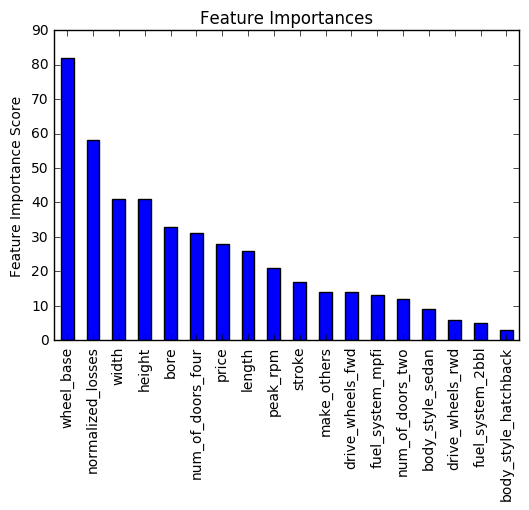

In [17]:
# xgboost classifier
xgb1 = XGBClassifier( learning_rate =0.05, n_estimators=250, max_depth=3, min_child_weight=5,
                     gamma=0.0, subsample=0.8, colsample_bytree=0.4,reg_alpha = 1e-05,
                     objective= 'binary:logistic', nthread=4, scale_pos_weight=1, seed=45)
#Choose the predictors for xgboost and fit the model
predictors = var
modelfit(xgb1, X_train, predictors)

In [18]:
feat_imp = pd.Series(xgb1.booster().get_fscore()).sort_values(ascending=False)

In [19]:
feat_imp

wheel_base              82
normalized_losses       58
width                   41
height                  41
bore                    33
num_of_doors_four       31
price                   28
length                  26
peak_rpm                21
stroke                  17
make_others             14
drive_wheels_fwd        14
fuel_system_mpfi        13
num_of_doors_two        12
body_style_sedan         9
drive_wheels_rwd         6
fuel_system_2bbl         5
body_style_hatchback     3
dtype: int64

In [21]:
# Train log_loss
y_predS = xgb1.predict_proba(X_train[var])
log_loss(y_train, y_predS[:,1])

0.1670901695618508

In [22]:
# Cross validation AUC & log_loss
cv_score = cross_val_score(xgb1, X_train[var], np.ravel(y_train), cv = 5, scoring ='roc_auc')
print 'mean auc: ' + str(cv_score.mean())
# print 'std auc: ' + str(cv_score.std())
cv_score1 = cross_val_score(xgb1, X_train[var], np.ravel(y_train), cv = 5, scoring ='log_loss')
print 'mean log_loss: ' + str(cv_score1.mean())
# print 'std log_loss: ' + str(cv_score1.std())

mean auc: 0.892819499341
mean log_loss: -0.470163627729


In [23]:
# Save the model
from sklearn.externals import joblib
joblib.dump(xgb1, '/home/pgoyal/Projects/xgb_250_logloss.pkl')

['/home/pgoyal/Projects/xgb_250_logloss.pkl',
 '/home/pgoyal/Projects/xgb_250_logloss.pkl_01.npy']

In [24]:
# Decile related info

df_list = [1,2,3,4,5,6,7,8,9,10]

prob = pd.DataFrame(y_predS[:,1]) # y_predS is to be changed
prob.columns = ['Probability']
prob["Target"] = y_train.values # y_train to be changed
prob = prob.sort_values(by='Probability', ascending=0)

dec = int(prob['Target'].shape[0]/10)

for i in [0,1,2,3,4,5,6,7,8,9]:
    vars()['dec_'+str(df_list[i])+'_rr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(dec))
    vars()['dec_'+str(df_list[i])+'_cr'] = float(prob['Target'][i*dec:(i+1)*dec].sum()/float(prob['Target'].sum()))
    vars()['dec_'+str(df_list[i])+'_goods'] = float(prob['Target'][i*dec:(i+1)*dec].sum())
    vars()['dec_'+str(df_list[i])+'_bads'] = float(prob['Target'][i*dec:(i+1)*dec].count())-float(
        prob['Target'][i*dec:(i+1)*dec].sum())

decile_num = pd.DataFrame([dec, dec, dec, dec, dec, dec, dec, dec, dec, dec], columns = ['# decile'])
decile_goods = pd.DataFrame([dec_1_goods, dec_2_goods, dec_3_goods, dec_4_goods, dec_5_goods, dec_6_goods, dec_7_goods,
                          dec_8_goods, dec_9_goods, dec_10_goods], columns = ['# of goods'])
decile_bads = pd.DataFrame([dec_1_bads, dec_2_bads, dec_3_bads, dec_4_bads, dec_5_bads, dec_6_bads, dec_7_bads,
                          dec_8_bads, dec_9_bads, dec_10_bads], columns = ['# of bads'])
decile_cr = pd.DataFrame([dec_1_cr, dec_2_cr, dec_3_cr, dec_4_cr, dec_5_cr, dec_6_cr, dec_7_cr,
                          dec_8_cr, dec_9_cr, dec_10_cr], columns = ['1st decile capture_rate'])
decile_rr = pd.DataFrame([dec_1_rr, dec_2_rr, dec_3_rr, dec_4_rr, dec_5_rr, dec_6_rr, dec_7_rr,
                          dec_8_rr, dec_9_rr, dec_10_rr], columns = ['1st decile response_rate'])

In [25]:
# Decile info dataframe

df = [decile_num, decile_goods, decile_bads, decile_cr, decile_rr]
df = pd.concat(df, axis=1)
df['% of bads'] = df['# of bads']/df['# of bads'].sum()
df['% cum_goods'] = df['1st decile capture_rate'].cumsum()
df['% cum_bads'] = df['% of bads'].cumsum()
df['KS'] = (df['% cum_goods']-df['% cum_bads']).max()
df['Lift'] = df['% cum_goods']/(df['# decile']/prob['Target'].shape[0]).cumsum()
df

# decile  # of goods  # of bads  1st decile capture_rate  \
0        20        20.0        0.0                 0.222222   
1        20        20.0        0.0                 0.222222   
2        20        20.0        0.0                 0.222222   
3        20        19.0        1.0                 0.211111   
4        20         8.0       12.0                 0.088889   
5        20         3.0       17.0                 0.033333   
6        20         0.0       20.0                 0.000000   
7        20         0.0       20.0                 0.000000   
8        20         0.0       20.0                 0.000000   
9        20         0.0       20.0                 0.000000   

   1st decile response_rate  % of bads  % cum_goods  % cum_bads        KS  \
0                      1.00   0.000000     0.222222    0.000000  0.868687   
1                      1.00   0.000000     0.444444    0.000000  0.868687   
2                      1.00   0.000000     0.666667    0.000000  0.868687   
3                      0.95   0.009091     0.877778    0.009091  0.868687   
4                      0.40   0.109091     0.966667    0.118182  0.868687   
5                      0.15   0.154545     1.000000    0.272727  0.868687   
6                      0.00   0.181818     1.000000    0.454545  0.868687   
7                      0.00   0.181818     1.000000    0.636364  0.868687   
8                      0.00   0.181818     1.000000    0.818182  0.868687   
9                      0.00   0.181818     1.000000    1.000000  0.868687   

       Lift  
0  2.233333  
1  2.233333  
2  2.233333  
3  2.205417  
4  1.943000  
5  1.675000  
6  1.435714  
7  1.256250  
8  1.116667  
9  1.005000

In [26]:
# Top decile, 5% capture, decile chart and lift chart

per5 = int(prob['Target'].shape[0]/20)
per5_1_rr = float(prob['Target'][0:per5].sum()/float(per5))
per5_1_cr = float(prob['Target'][0:per5].sum()/float(prob['Target'].sum()))

print 'Probability from meta classifier'
print 'Response 10%: ' + str(dec_1_rr)
print 'Capture at 10%: ' + str(dec_1_cr)
print 'Response 5%: ' + str(per5_1_rr)
print 'Capture at 5%: ' + str(per5_1_cr)

# print decile chart and lift chart
f, axs = plt.subplots(1,2,figsize=(16,4))
axs[0].bar(range(0,10), df['1st decile capture_rate'], color = 'blue'), axs[0].set_title('Decile chart')
axs[0].set_ylabel('Capture rate')
axs[1].bar(range(0,10), df['Lift'], color = 'grey'), axs[1].set_title('Lift chart'), axs[1].set_ylabel('Lift')

Probability from meta classifier
Response 10%: 1.0
Capture at 10%: 0.222222222222
Response 5%: 1.0
Capture at 5%: 0.111111111111


(<Container object of 10 artists>,
 <matplotlib.text.Text at 0x7f7aed41be10>)